In [1]:
%reload_ext eradiate.notebook.tutorials

*Last updated: 2025-03-11 09:42 (eradiate v0.29.3.dev0)*

## Background

Polarization in Eradiate follows the implementation of our radiometric kernel [Mitsuba](https://mitsuba.readthedocs.io/en/stable/). 

When simulating polarized light, Eradiate transports 4x1 Stokes vectors $\mathbf{s}=[s_0,s_1,s_2,s_3]^\intercal$ instead of radiance. It is a 4 dimensional quantity which parametrizes the state of light [[1]](https://mitsuba.readthedocs.io/en/stable/src/key_topics/polarization.html):

* $s_0$ is the scalar radiance. It represents the intensity without giving information about the polarization state.
* $s_1$ is the horizontal and vertical polarization. $\pm1$ values signify light is fully polarized at $0^\circ$ and $90^\circ$ respectively. 
* $s_2$ is the diagonal polarization. $\pm1$ values signify light is fully polarized at $45^\circ$ and $135^\circ$ respectively. 
* $s_3$ is the circular polarization. $\pm1$ values signify light is fully polarized right and left circulary respectively

Another quantity of interest is the Degree of Linear Polarization, $\text{DLP}$ :
$$\text{DLP} = \frac{\sqrt{s_1^2 + s_2^2}}{s_0}$$
which describes the amount of light that is linearly polarized. A value of 1 is fully linear.

## Let there be polarized light

We will first cover how to turn on polarization in Eradiate and visualize the Stokes vector and Degree of Linear Polarization (DLP).

In [2]:
import eradiate
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from eradiate import scenes as ertsc
from eradiate import unit_registry as ureg

Turning on polarization in Eradiate is as easy as setting the correct eradiate mode. More specifically, you can use `'mono_polarized'` for single band simulation and `'ckd_polarized'` for CKD simulations.

In [3]:
eradiate.set_mode("mono_polarized")

In [4]:
eradiate.modes()

['mono_single',
 'mono_polarized_single',
 'mono_double',
 'mono_polarized_double',
 'ckd_single',
 'ckd_polarized_single',
 'ckd_double',
 'ckd_polarized_double',
 'mono',
 'mono_polarized',
 'ckd',
 'ckd_polarized']

Let's do our first polarized simulation. We will create a scene where polarization effects are strong and compare the result to a scalar simulation. 

Here, we prepare a standard atmosphere experiment with a non-absorbing molecular atmosphere measured at `400 nm`. The Rayleigh scattering at the given wavelength will display strong polarization effects. 

In [5]:
def run_exp(spp, integrator=None):
    """
    Generate and run an atmosphere experiment over a hemisphere plane cut.
    """

    if integrator is None:
        integrator = ertsc.integrators.VolPathIntegrator()

    measure = ertsc.measure.MultiDistantMeasure.hplane(
        zeniths=np.arange(-85, 86, 5),
        azimuth=0.0,
        spp=spp,
        srf={"type": "multi_delta", "wavelengths": 400 * ureg.nm},
    )

    exp = eradiate.experiments.AtmosphereExperiment(
        surface={
            # Note: Lambertian surfaces act as depolarizers, set this to 0 to see more effect.
            "type": "lambertian",
            "reflectance": 0.5,
        },
        illumination={
            "type": "directional",
            "zenith": 30,
            "azimuth": 0,
        },
        atmosphere={"type": "molecular", "has_absorption": False},
        measures=measure,
        integrator=integrator,
    )

    return eradiate.run(exp, spp=spp)


In [6]:
eradiate.set_mode("mono_polarized")
polarized_result = run_exp(spp=100000)

To see the effect, let's compare this to a scalar (unpolarized) simulation.

In [7]:
# Let's run the same experiment without polarization
eradiate.set_mode("mono")
scalar_result = run_exp(spp=100000)

# make sure to do the rest of the tutorial in polarized mode!
eradiate.set_mode("mono_polarized")

By plotting the scalar and polarized results, we can see that polarization has a big effect on the resulting radiance! 

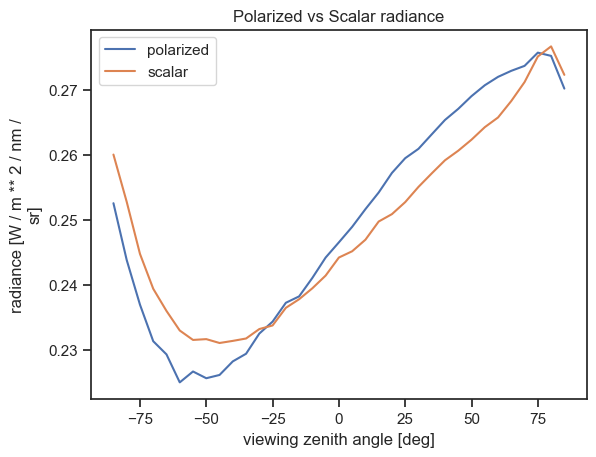

In [8]:
polarized_result.radiance.squeeze().plot(x="vza", label="polarized")
scalar_result.radiance.squeeze().plot(x="vza", label="scalar")
plt.title("Polarized vs Scalar radiance")
plt.legend()
plt.show()

Polarization in Eradiate is represented by Stokes vectors, which can be visualized in a simulation output. To do so, you just need to set `stokes` to `True` in the integrator.

In [9]:
# Set stokes to True to see the Stokes vector as an output of the simulation
integrator = ertsc.integrators.VolPathIntegrator(stokes=True)

# Let's run the simulation again with this integrator
stokes_result = run_exp(spp=100000, integrator=integrator)

The result appears as a new dimension and coordinate in the result of the radiance. Also note the new `dlp` variable that denotes the Degree of Linear Polarization.

In [10]:
stokes_result

<xarray.Dataset> Size: 3kB
Dimensions:     (sza: 1, saa: 1, w: 1, y_index: 1, x_index: 35, stokes: 4)
Coordinates:
  * sza         (sza) int64 8B 30
  * saa         (saa) int64 8B 0
  * w           (w) float64 8B 400.0
  * y_index     (y_index) int64 8B 0
    y           (y_index) float64 8B 0.0
  * x_index     (x_index) int64 280B 0 1 2 3 4 5 6 7 ... 27 28 29 30 31 32 33 34
    x           (x_index) float64 280B 0.0 0.02941 0.05882 ... 0.9412 0.9706 1.0
  * stokes      (stokes) <U1 16B 'I' 'Q' 'U' 'V'
    vza         (x_index, y_index) int64 280B -85 -80 -75 -70 ... 70 75 80 85
    vaa         (x_index, y_index) int64 280B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Data variables:
    radiance    (w, stokes, y_index, x_index, saa, sza) float64 1kB 0.2516 .....
    brdf        (w, y_index, x_index, saa, sza) float64 280B 0.1738 ... 0.1862
    brf         (w, y_index, x_index, saa, sza) float64 280B 0.5459 ... 0.5851
    dlp         (w, y_index, x_index, saa, sza) float64 280B 0.3632 ... 0.2728
    irradiance  (sza, saa, w) float64 8B 1.448

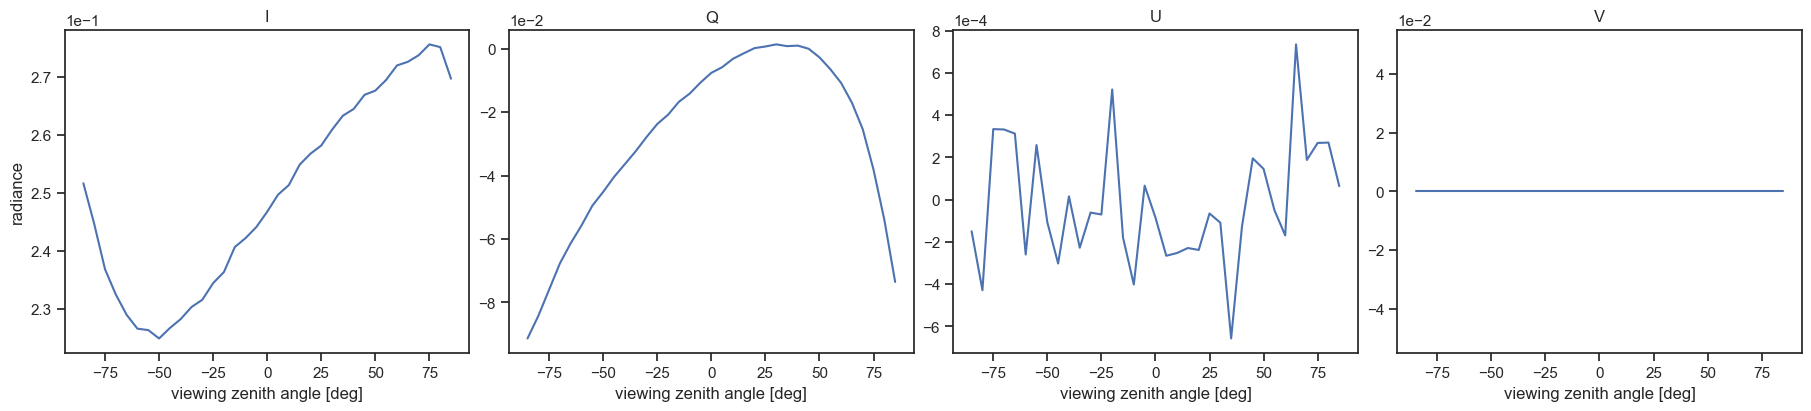

In [11]:
# Let's visualize the Stokes vector ...
fig, axs = plt.subplots(1, 4, figsize=(4 * 4.5, 4), layout="constrained")
for ax, stoke in zip(axs, ["I", "Q", "U", "V"]):
    ax.plot(
        stokes_result.vza, stokes_result.radiance.squeeze().sel(stokes=stoke).values
    )
    ax.set_xlabel("viewing zenith angle [deg]")
    ax.ticklabel_format(axis="y", scilimits=[-1, 1])
    if stoke == "I":
        ax.set_ylabel("radiance")
    ax.set_title(stoke)
plt.show()

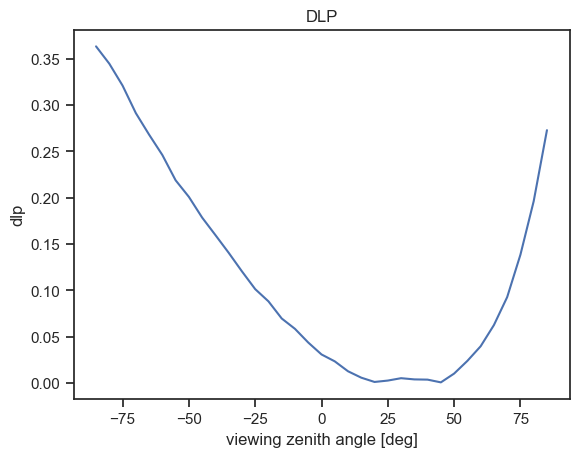

In [12]:
# ... and the degree of linear polarization
stokes_result.dlp.squeeze().plot(x="vza")
plt.title("DLP")
plt.show()

It is possible to have a variance report on the Stokes components by setting the `moment` parameter of the integrator to `True`:

In [13]:
integrator = ertsc.integrators.VolPathIntegrator(stokes=True, moment=True)
var_result = run_exp(spp=10000, integrator=integrator)
var_result

<xarray.Dataset> Size: 4kB
Dimensions:       (sza: 1, saa: 1, w: 1, y_index: 1, x_index: 35, stokes: 4)
Coordinates:
  * sza           (sza) int64 8B 30
  * saa           (saa) int64 8B 0
  * w             (w) float64 8B 400.0
  * y_index       (y_index) int64 8B 0
    y             (y_index) float64 8B 0.0
  * x_index       (x_index) int64 280B 0 1 2 3 4 5 6 7 ... 28 29 30 31 32 33 34
    x             (x_index) float64 280B 0.0 0.02941 0.05882 ... 0.9706 1.0
  * stokes        (stokes) <U1 16B 'I' 'Q' 'U' 'V'
    vza           (x_index, y_index) int64 280B -85 -80 -75 -70 ... 70 75 80 85
    vaa           (x_index, y_index) int64 280B 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Data variables:
    radiance      (w, stokes, y_index, x_index, saa, sza) float64 1kB 0.2524 ...
    radiance_var  (w, stokes, y_index, x_index, saa, sza) float64 1kB 3.298e-...
    brdf          (w, y_index, x_index, saa, sza) float64 280B 0.1743 ... 0.1872
    brf           (w, y_index, x_index, saa, sza) float64 280B 0.5476 ... 0.5882
    dlp           (w, y_index, x_index, saa, sza) float64 280B 0.3681 ... 0.2647
    irradiance    (sza, saa, w) float64 8B 1.448

Note here the new `radiance_var` variable that includes the radiance variance for each stokes component. We can visualize two standard deviations like so:

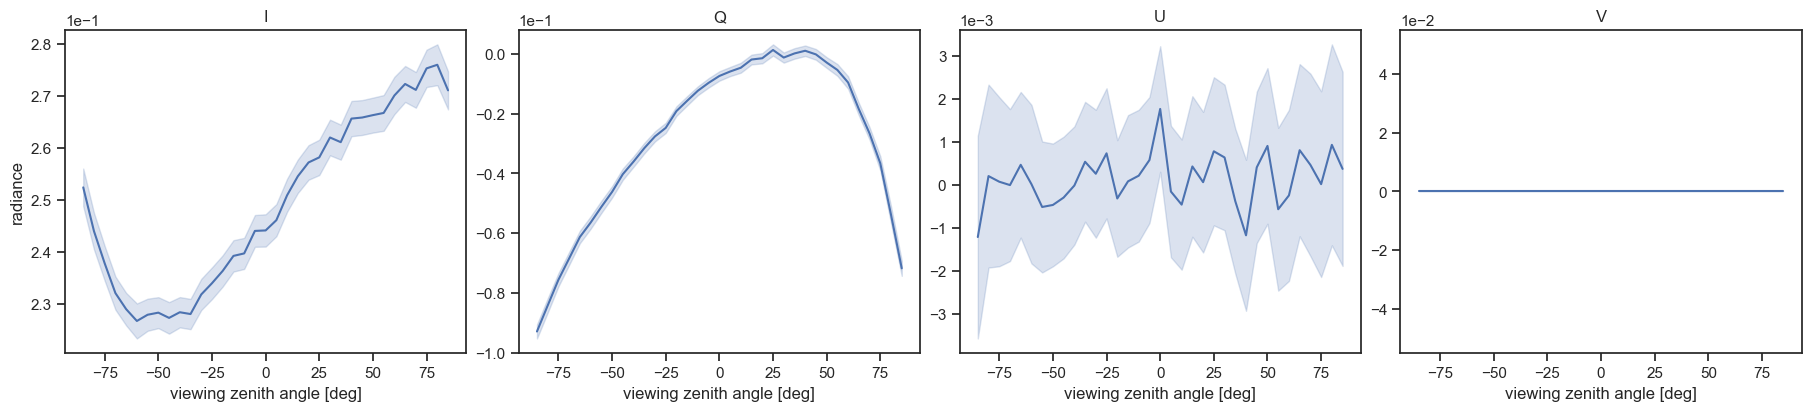

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(4 * 4.5, 4), layout="constrained")

std = np.sqrt(var_result.radiance_var)
upper = (var_result.radiance + 2 * std).squeeze()
lower = (var_result.radiance - 2 * std).squeeze()
vza = var_result.vza.squeeze()

for ax, stoke in zip(axs, ["I", "Q", "U", "V"]):
    ax.plot(var_result.vza, var_result.radiance.squeeze().sel(stokes=stoke).values)
    ax.set_xlabel("viewing zenith angle [deg]")
    ax.ticklabel_format(axis="y", scilimits=[-1, 1])
    ax.fill_between(
        vza, upper.sel(stokes=stoke), lower.sel(stokes=stoke), alpha=0.2, color="C0"
    )
    ax.set_title(stoke)
    if stoke == "I":
        ax.set_ylabel("radiance")

## Polarization parameters

We will now see how to configure scene parameters tied to polarization.

### Molecular Atmosphere

Scattering interactions in a molecular atmosphere are modelled by Rayleigh scattering, which is dependent on the depolarization factor. This can be specified like so:

In [15]:
ertsc.atmosphere.MolecularAtmosphere(rayleigh_depolarization=0.03)

MolecularAtmosphere(id='atmosphere', geometry=PlaneParallelGeometry(toa_altitude=120.0 km, ground_altitude=0.0 km, zgrid=ZGrid(levels=[0.0 100.0 200.0 ... 119800.0 119900.0 120000.0] m, _layers=[50.0 150.0 250.0 ... 119750.0 119850.0 119950.0] m, _layer_height=100.0 m, _total_height=120000.0 m), width=1000000.0 km), scale=None, force_majorant=False, _absorption_data=<MonoAbsorptionDatabase> /home/leroyv/Documents/src/rayference/eradiate/.eradiate_downloads/stable/spectra/absorption/mono/komodo
Access mode: lazy
Index:
        filename  wn_min [cm^-1]  ...  wl_min [nm]  wl_max [nm]
    0  komodo.nc          3200.0  ...     250.0021       3125.0

    [1 rows x 5 columns], _thermoprops=<xarray.Dataset>, has_absorption=True, has_scattering=True, rayleigh_depolarization=array(0.03), _radprops_profile=AtmosphereRadProfile(absorption_data=<MonoAbsorptionDatabase> /home/leroyv/Documents/src/rayference/eradiate/.eradiate_downloads/stable/spectra/absorption/mono/komodo
Access mode: lazy
Index:
 

### Particle Layers

In Eradiate, particle layers represent various particles and aerosols in the air. They are modelled by a tabulated phase function, which accepts an arbitrary phase function defined over `mu`, the cosine scattering angle. Aerosol and particle datasets allow for polarized phase functions.

To demonstrate this, we will use the particle data provided by the IPRT benchmark for cases A3 and A4 for water soluble spherical particles and spheroidal particles respectively. 

In [16]:
spherical = eradiate.data.load_dataset("tutorials/spectra/particles/iprt.waso.mie.nc")
spheroidal = eradiate.data.load_dataset(
    "tutorials/spectra/particles/iprt.sizedistr_spheroid.nc"
)

In [17]:
# note the i and j dimensions which are the indices of the phase matrix.
display(spherical)

<xarray.Dataset> Size: 9kB
Dimensions:  (w: 1, mu: 68, i: 4, j: 4)
Coordinates:
  * w        (w) float64 8B 350.0
  * mu       (mu) float32 272B -1.0 -0.9998 -0.9962 ... 0.9962 0.9998 1.0
  * i        (i) int64 32B 0 1 2 3
  * j        (j) int64 32B 0 1 2 3
Data variables:
    sigma_t  (w) float64 8B 3.566e+03
    albedo   (w) float64 8B 0.9757
    phase    (w, mu, i, j) float64 9kB 0.2446 -1.498e-07 0.0 ... 8.559e-09 4.671
Attributes:
    source:   Internal Polarized Radiative Transfer polarized radiative trans...

The phase data variable is a 4x4 matrix dependent on `w` (wavelength), and `mu` (cosine scattering angle). The coefficients of the matrix are accessible through the `i` and `j` indexes. Note the only difference with scalar datasets is the size of dimensions `i` and `j` which would be equal to 1. You can find more information about aerosol datasets [here](https://eradiate.readthedocs.io/en/stable/rst/data/aerosols_particles.html).

Let's have a look at the matrices we just loaded.

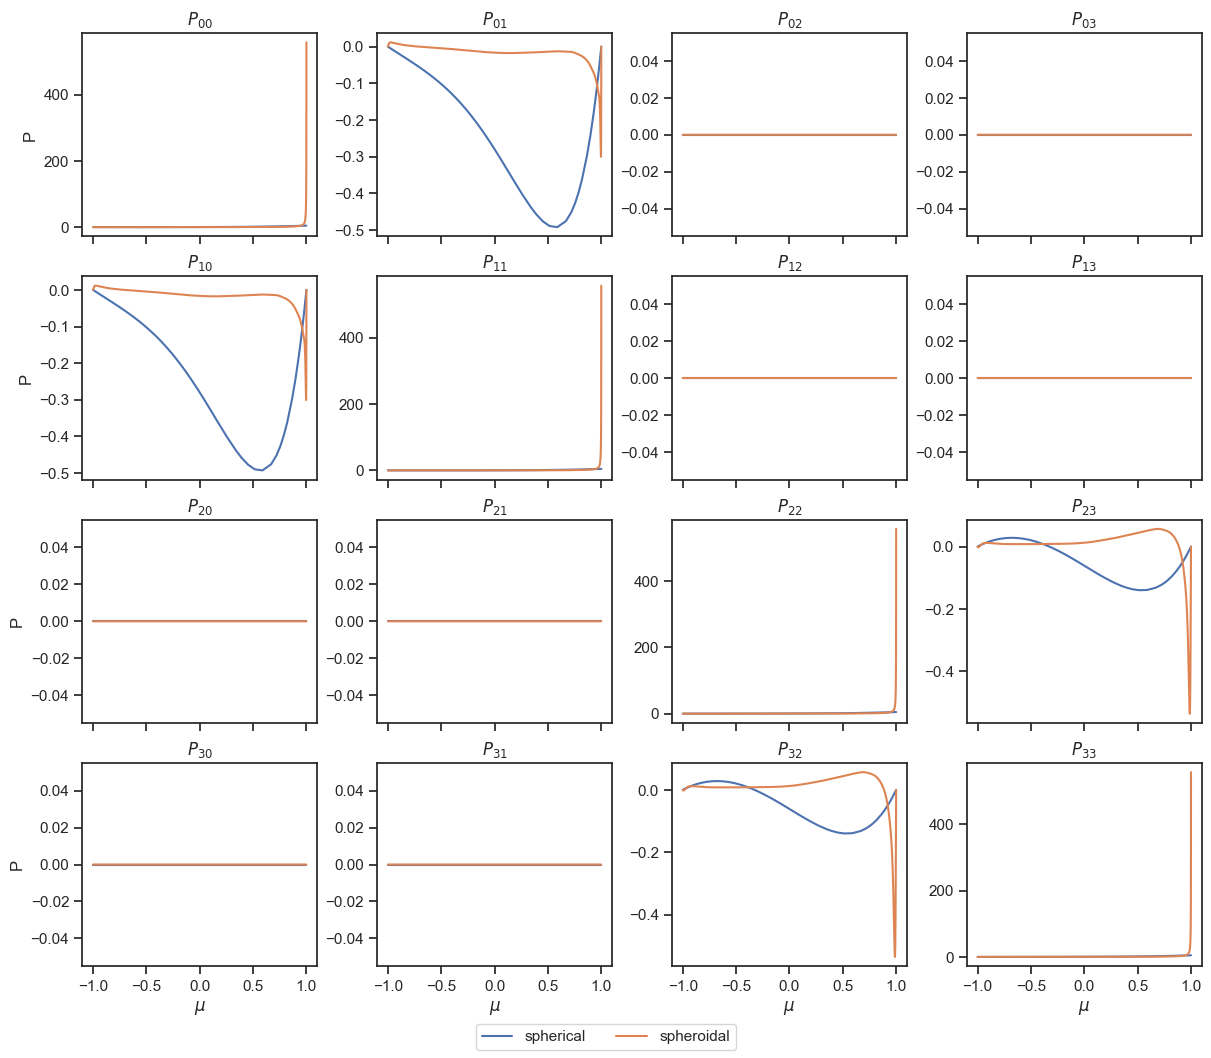

In [18]:
fig, axs = plt.subplots(
    4, 4, figsize=(3 * 4, 3 * 3.5), layout="constrained", sharex=True
)
mu_spherical = spherical.mu.values
mu_spheroidal = spheroidal.mu.values

for i in range(4):
    for j in range(4):
        label_spherical = "spherical" if (i == 0 and j == 0) else None
        label_spheroidal = "spheroidal" if (i == 0 and j == 0) else None
        axs[i, j].plot(
            mu_spherical,
            spherical.phase.isel(w=0, i=i, j=j).values,
            label=label_spherical,
        )
        axs[i, j].plot(
            mu_spheroidal,
            spheroidal.phase.isel(w=0, i=i, j=j).values,
            label=label_spheroidal,
        )
        axs[i, j].set_title(f"$P_{{{i}{j}}}$")
        if j == 0:
            axs[i, j].set_ylabel("P")
        if i == 3:
            axs[i, j].set_xlabel("$\mu$")

fig.legend(loc="outside lower center", ncols=2)
plt.show()

The particle layer is initialized with the aerosol dataset and the shape of the particle, which can be either `spherical` or `spheroidal`. Note that the shape is essential as it defines which coefficients are used by the kernel.

In [19]:
# The following lines are required to avoid the error reported at https://github.com/eradiate/eradiate/issues/457.
# This only applies to aerosol dataset are defined only by one wavelength.
spherical_bis = xr.concat([spherical, spherical], dim="w")
spherical_bis.w.values[0] = 340
spherical_bis.w.values[1] = 360

spheroidal_bis = xr.concat([spheroidal, spheroidal], dim="w")
spheroidal_bis.w.values[0] = 340
spheroidal_bis.w.values[1] = 360

In [20]:
spherical_layer = ertsc.atmosphere.ParticleLayer(
    bottom=0 * ureg.km,
    top=1 * ureg.km,
    tau_ref=0.5,
    w_ref=350 * ureg.nm,
    dataset=spherical_bis,
    distribution="uniform",
    particle_shape="spherical",
)

spheroidal_layer = ertsc.atmosphere.ParticleLayer(
    bottom=0 * ureg.km,
    top=1 * ureg.km,
    tau_ref=0.5,
    w_ref=350 * ureg.nm,
    dataset=spheroidal_bis,
    distribution="uniform",
    particle_shape="spheroidal",
)

We will finish by comparing the effect of the spherical and spheroidal particle layers that we just created. 

In [21]:
def run_aerosol_exp(spp, particle_layer):
    """
    Generate and run an atmosphere experiment over a hemisphere plane cut.
    """

    measure = ertsc.measure.MultiDistantMeasure.hplane(
        zeniths=np.arange(-85, 86, 5),
        azimuth=0.0,
        spp=spp,
        srf={"type": "multi_delta", "wavelengths": 350 * ureg.nm},
    )

    exp = eradiate.experiments.AtmosphereExperiment(
        surface={"type": "lambertian", "reflectance": 0.5},
        illumination={
            "type": "directional",
            "zenith": 30,
            "azimuth": 0,
        },
        atmosphere=particle_layer,
        measures=measure,
        integrator={"type": "volpath", "stokes": True},
    )

    return eradiate.run(exp, spp=spp)

In [22]:
spherical_result = run_aerosol_exp(10000, spherical_layer)
spheroidal_result = run_aerosol_exp(10000, spheroidal_layer)

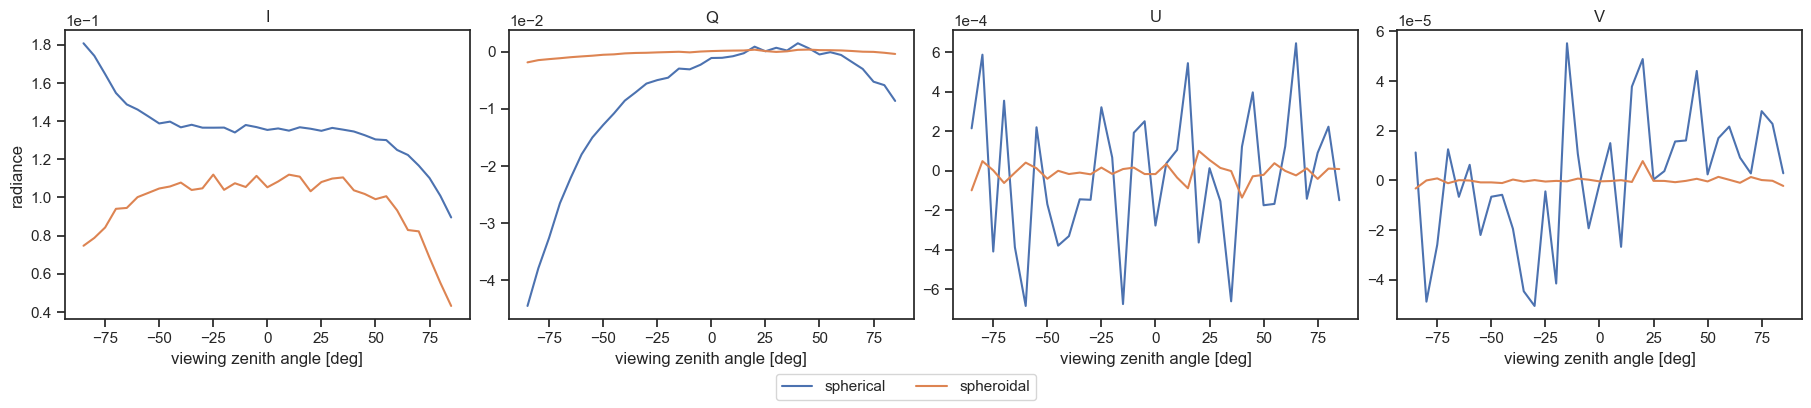

In [23]:
# Let's visualize the Stokes vector
fig, axs = plt.subplots(1, 4, figsize=(4 * 4.5, 4), layout="constrained")
for ax, stoke in zip(axs, ["I", "Q", "U", "V"]):
    label_spherical = "spherical" if (stoke == "I") else None
    label_spheroidal = "spheroidal" if (stoke == "I") else None
    ax.plot(
        spherical_result.vza,
        spherical_result.radiance.squeeze().sel(stokes=stoke).values,
        label=label_spherical,
    )
    ax.plot(
        spheroidal_result.vza,
        spheroidal_result.radiance.squeeze().sel(stokes=stoke).values,
        label=label_spheroidal,
    )
    ax.set_title(stoke)
    ax.set_xlabel("viewing zenith angle [deg]")
    ax.ticklabel_format(axis="y", scilimits=[-1, 1])
    if stoke == "I":
        ax.set_ylabel("radiance")

fig.legend(loc="outside lower center", ncols=2)
plt.show()

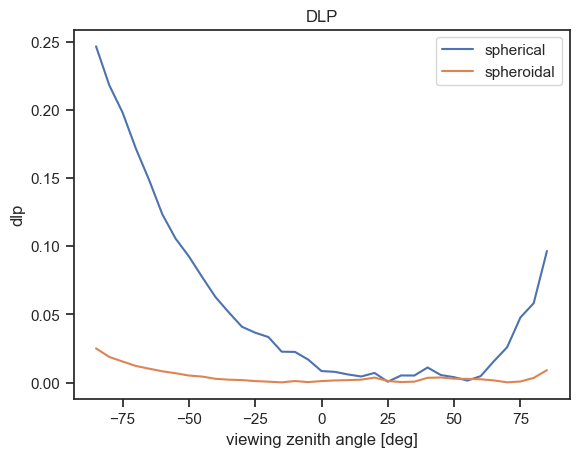

In [24]:
spherical_result.dlp.squeeze().plot(x="vza", label="spherical")
spheroidal_result.dlp.squeeze().plot(x="vza", label="spheroidal")
plt.title("DLP")
plt.legend()
plt.show()